# Standard start

Thanks and acknowledgement to gapminder.org for providing the used data!
Original data and references https://www.gapminder.org/data/


Always first run the below cell.


The dataframe_management script extracts the requested data as a dataframe, indexed by year for either global average or country specific, while my_tools script contains small functions to clean up data and plot graphs.


In [1]:
from data_management import get_data, get_country_data, get_global_data, get_all_data
import data_tools as tools
import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The next cell contains all the data sets that are available, ordered per category.
These are the exact attribute names that the get_data() functions accept.

#### Education: 
        primary_school_cost
        primary_school_completion
        
#### health: 
        sanitation_access
        water_access
        life_expectancy
        
#### population: 
        child_mortality
        ratio_child_and_elderly
        children_per_mother
        median_age
        population_density
        population
        
#### wealth: 
        av_age_billionaires
        gdp_yearly_growth
        income_per_person
        inflation
        people_in_poverty
        tax_perc_gdp
        amount_billionaires
        
#### other: 
        co2_emissions
        corruption_ind
        hdi

## Example

First we will show some simple functionality with the toolset that was created.
The functions below will, for the requested attributes, calculate the global average per attribute, per year, return this in one dataset with Year as index. Followed by a normalization tool, with the cache used to denormalize.

In [2]:
attributes = ['child_mortality', 'population', 'children_per_mother', 'income_per_person', 'life_expectancy']

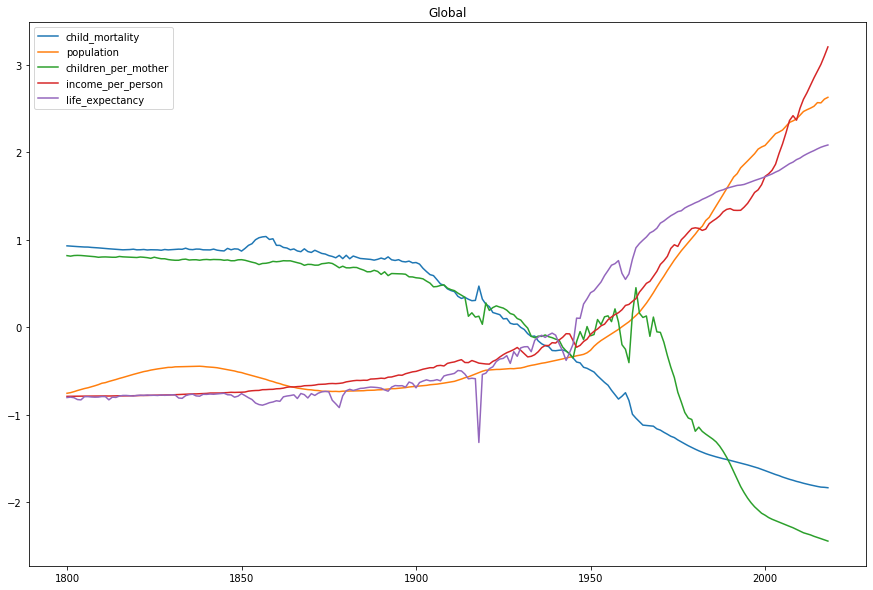

In [61]:
global_av = get_global_data(attributes)
global_norm, global_cache = tools.normalize(global_av)
tools.plot_big(global_norm)

Now we will start preparing data to be able to train a network with.

The follow get_all_data function will cycle through all the countries the first attribute has avaible, see if that county has data on all attributes for a given year and if so, will add this these to one big dataframe.

The goal here is to see if we can train a model that can make predictions that come close to the global average.
For this we will make our validation set a random assortement of entries we have available now to try not to have a bias towards any time. Also note that since we will be training on a set of localised (country) values and we want to predict the average, the validation will most likely not be very accurate.

Though hopefully when we test the trained network on the global average information we procured in the above section, the neural net will perform better.

Dataset has (219, 5) entries.
Data starts from: 1800, until 2018

	Column               | Type     | Min          | Max         

	child_mortality      | float64  |         28.8 |        448.7
	population           | float64  |  145779005.6 |  574999699.6
	children_per_mother  | float64  |          2.4 |          5.8
	income_per_person    | float64  |       1121.7 |      15566.4
	life_expectancy      | float64  |         23.4 |         73.1

Dataset has (40294, 6) entries.
Data starts from: Afghanistan, until Zimbabwe

	Column               | Type     | Min          | Max         

	year                 | float64  |         -1.7 |          1.7
	child_mortality      | float64  |         -1.8 |          2.9
	population           | float64  |         -0.2 |         21.3
	children_per_mother  | float64  |         -2.6 |          2.1
	income_per_person    | float64  |         -0.4 |         17.0
	life_expectancy      | float64  |         -2.6 |          2.5



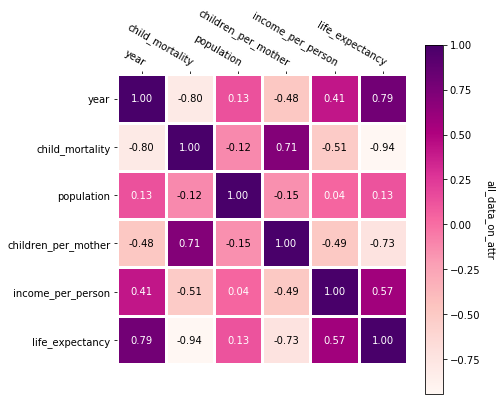

In [5]:
all_data = get_all_data(attributes)
tools.show_content(data)

all_data_norm, all_data_cache = tools.normalize(all_data)
tools.show_content(all_data_norm)
tools.plot_heatmap(all_data_norm, (7,6))

To make the random selection for the validation set we will use numpy to make a mask for the dataframe that keeps, randomly, 80% of the data.

In [6]:
cor = all_data_norm.corr()

cor_target = abs(cor["life_expectancy"])
relevant_features = cor_target[cor_target>0.5]
relevant_features.index.tolist()

['year',
 'child_mortality',
 'children_per_mother',
 'income_per_person',
 'life_expectancy']

In [62]:
train_set, val_set = tools.get_random_val_set(all_data_norm[relevant_features.index.tolist()])

In [63]:
train_X = train_set.loc[:, train_set.columns != 'life_expectancy']
train_Y = train_set.loc[:, train_set.columns == 'life_expectancy']
print(f"Shape of train_X: {train_X.shape}")
print(f"Shape of train_Y: {train_Y.shape}")

val_X = val_set.loc[:, val_set.columns != 'life_expectancy']
val_Y = val_set.loc[:, val_set.columns == 'life_expectancy']
print(f"Shape of val_X: {val_X.shape}")
print(f"Shape of val_Y: {val_Y.shape}")

Shape of train_X: (32235, 4)
Shape of train_Y: (32235, 1)
Shape of val_X: (8059, 4)
Shape of val_Y: (8059, 1)


In [ ]:
nn_param, cost = nn.train_network([4,3,1], train_X, train_Y, 50, optimizer='adam', L2=False)

In [ ]:
plt.plot(cost)
plt.show()

In [64]:
global_av['year'] = global_av.index
global_norm, global_cache = tools.normalize(global_av)

global_norm = global_norm[relevant_features.index.tolist()]

global_X = global_norm.loc[:, global_norm.columns != 'life_expectancy']
global_Y = global_norm.loc[:, global_norm.columns == 'life_expectancy']

In [65]:
to_pred1 = val_X[val_X.index.str.startswith('Zimbab')]

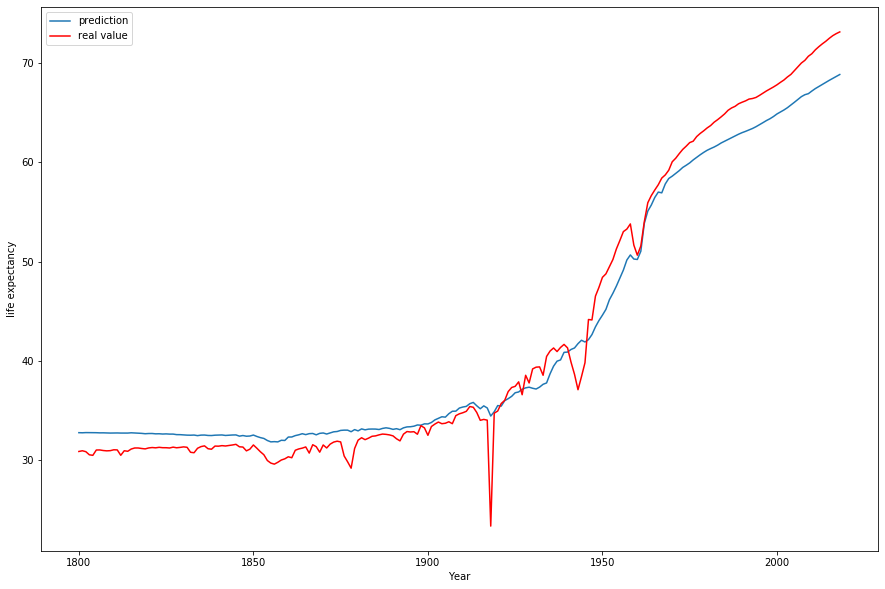

In [66]:
pred = nn.predict(nn_param, global_X)

real_pred = pred * data_cache[1]['life_expectancy'] + data_cache[0]['life_expectancy']
real = global_Y * global_cache[1]['life_expectancy'] + global_cache[0]['life_expectancy']

plt.figure(figsize=(15,10))
plt.plot(global_X.index, real_pred, label='prediction')
plt.plot(global_X.index, real, color='red', label='real value')
plt.xlabel('Year')
plt.ylabel('life expectancy')
plt.legend()
plt.show()